In [61]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts, raster_plot

# Example cache directory path, it determines where downloaded data will be stored
output_dir = './ecephys_cache_dir/'

manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

pd.set_option('display.max_columns', None)

In [2]:
session_id = 721123822 # 797828357
session = cache.get_session_data(session_id)

## Get units in area of interest

In [ ]:
VI_structure_acronyms = [x for x in cache.get_structure_acronyms() if x is not np.nan and 'VI' in x]

In [24]:
# units in a session after quality filter
VI_units = session.units.loc[[i for i, x in session.units.iterrows() if x['ecephys_structure_acronym'] in VI_structure_acronyms]]
len(VI_units)

214

In [23]:
# # Spike time data is missing for units filtered out in a session
# units = cache.get_units(amplitude_cutoff_maximum = np.inf,
#                         presence_ratio_minimum = -np.inf,
#                         isi_violations_maximum = np.inf)
# units = units[units['ecephys_session_id'] == session_id]

# VI_units_all = units.loc[[i for i, x in units.iterrows() if x['ecephys_structure_acronym'] in VI_structure_acronyms]]
# len(VI_units_all)

622

### Find center channel

In [31]:
ecephys_structure_acronyms = 'VISp'
sel_units = VI_units[VI_units['ecephys_structure_acronym'] == ecephys_structure_acronyms]
# sel_units = VI_units

In [32]:
# units center
ccf_coords = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
units_coord = sel_units[ccf_coords].values
units_coord_mean = units_coord.mean(axis=0)
center_unit_id = sel_units.index[np.argmin(np.sum((units_coord - units_coord_mean) ** 2, axis=1))]

channel_index = sel_units.loc[center_unit_id, 'probe_channel_number']
probe_id = sel_units.loc[center_unit_id, 'probe_id']

channel = session.channels[(session.channels.probe_channel_number == channel_index) & 
                           (session.channels.probe_id == probe_id)]
channel

,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,,
850245985,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,234,59,760213145,2360,VISp,385.0,VISp,8650.0,1130.0,8035.0


In [33]:
# channels center
channels_coord = session.channels[ccf_coords].values
center_channel_id = session.channels.index[np.argmin(np.sum((channels_coord - units_coord_mean) ** 2, axis=1))]
session.channels.loc[[center_channel_id]]

,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,,
850245983,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,233,11,760213145,2340,VISp,385.0,VISp,8646.0,1141.0,8035.0


## Analyze spikes

In [59]:
def align_gratings(stimulus_presentations, stimulus_name='drifting_gratings'):
    presentations = stimulus_presentations[stimulus_presentations.stimulus_name == stimulus_name]
    null_rows = presentations[presentations['orientation'].values == 'null']
    if len(null_rows):
        null_condition = null_rows.iloc[0]['stimulus_condition_id']
        presentations = presentations[presentations['stimulus_condition_id'] != null_condition]

    presentations_times = presentations['start_time'].values
    presentations_ids = presentations.index.values
    trial_duration = presentations['duration'].max()
    return presentations, presentations_ids, presentations_times, trial_duration

def presentation_conditions(presentations, condtion_types):
    conditions = {c: np.unique(presentations[c]).astype(float) for c in condtion_types}
    cond_id_map = dict(zip(map(tuple, presentations[conditions.keys()].values),
                           presentations['stimulus_condition_id']))
    condition_id = [cond_id_map[x, y] for x, y in zip(*map(np.ravel, np.meshgrid(*conditions.values(), indexing='ij')))]
    condition_id = xr.DataArray(np.reshape(condition_id, tuple(map(len, conditions.values()))), coords=conditions, name='condition_id')
    cond_presentation_id = {c: presentations.index[presentations['stimulus_condition_id'] == c] for c in condition_id.values.ravel()}
    return condition_id, cond_presentation_id

In [62]:
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name='drifting_gratings')

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

In [63]:
bin_width = 0.03 # sec
window = (-0.5, grating_duration)
bin_edges = np.concatenate((np.arange(0., window[0] - bin_width, -bin_width)[:0:-1],
                            np.arange(0, window[1] + bin_width, bin_width)))

units_fr = session.presentationwise_spike_counts(stimulus_presentation_ids=grating_ids, unit_ids=sel_units.index, bin_edges=bin_edges)
units_fr = [units_fr.sel(stimulus_presentation_id=i).mean(dim='stimulus_presentation_id') for i in cond_presentation_id.values()]
units_fr = xr.concat(units_fr, dim=pd.Index(cond_presentation_id, name='condition_id'))
# units_fr_cond = units_fr.sel(condition_id=condition_id)

In [93]:
units_fr

<xarray.DataArray 'spike_counts' (condition_id: 40,
                                  time_relative_to_stimulus_onset: 84,
                                  unit_id: 41)>
array([[[0.        , 0.        , 0.26666667, ..., 0.06666667,
         0.        , 0.        ],
        [0.        , 0.        , 0.33333333, ..., 0.26666667,
         0.        , 0.        ],
        [0.        , 0.        , 0.33333333, ..., 0.06666667,
         0.06666667, 0.        ],
        ...,
        [0.        , 0.        , 0.93333333, ..., 0.53333333,
         0.26666667, 0.06666667],
        [0.06666667, 0.        , 1.        , ..., 0.73333333,
         0.13333333, 0.13333333],
        [0.06666667, 0.        , 0.86666667, ..., 0.8       ,
         0.06666667, 0.13333333]],

       [[0.        , 0.06666667, 0.4       , ..., 0.2       ,
         0.        , 0.        ],
        [0.        , 0.        , 0.4       , ..., 0.        ,
         0.        , 0.        ],
        [0.06666667, 0.        , 0.4       , ..., 0.26666667,
         0.        , 0.        ],
...
        [0.        , 0.13333333, 0.06666667, ..., 0.33333333,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.4       ,
         0.        , 0.        ],
        [0.        , 0.06666667, 0.06666667, ..., 0.2       ,
         0.06666667, 0.        ]],

       [[0.        , 0.        , 0.33333333, ..., 0.06666667,
         0.        , 0.        ],
        [0.        , 0.        , 0.46666667, ..., 0.06666667,
         0.06666667, 0.        ],
        [0.        , 0.        , 0.33333333, ..., 0.13333333,
         0.06666667, 0.        ],
        ...,
        [0.        , 0.        , 0.26666667, ..., 0.53333333,
         0.        , 0.        ],
        [0.        , 0.06666667, 0.        , ..., 0.26666667,
         0.06666667, 0.        ],
        [0.        , 0.06666667, 0.2       , ..., 0.33333333,
         0.06666667, 0.        ]]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 950908795 ... 950908653
  * condition_id                     (condition_id) int64 271 277 ... 273 246

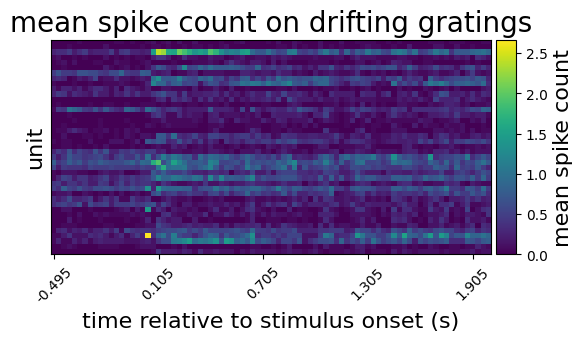

In [95]:
units_fr0 = units_fr.isel(condition_id=[0])
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0['time_relative_to_stimulus_onset'],
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)
plt.show()

In [72]:
# spike_times = session.presentationwise_spike_times(stimulus_presentation_ids=grating_ids, unit_ids=sel_units.index)

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1587.523334,3798,950908551,0.000612
1587.529967,3798,950908442,0.007245
1587.530701,3798,950908544,0.007978
1587.533701,3798,950908496,0.010978
1587.540901,3798,950908479,0.018178
...,...,...,...
5393.688327,49430,950908448,1.988908
5393.695227,49430,950908489,1.995808
5393.696527,49430,950908485,1.997108
